# Logistic Regression for Residence Type Classification

This notebook referenced https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

This notebook will demonstrate the classfication process of classifying 'Other' residence type into either 'House' type or 'Apartment' type using logistic regression model.

The reason for using logistic regression model is because our model satisifies the following assumptions of logistic regression:

1. output class: residence type is binary (1: House, 0: Apartment). 

2. observations are independent of each other: each rental records are independet of other records. 

3. independent variables are not be too highly correlated with each other.

4. logistic regression assumes linearity of independent variables and log odds. 

5. large sample size.


**Input variables**

* number of bedrooms: numeric

* number of bathrooms: numeric

* number of carspace: numeric

* weekly rent value: numeric

* year: categorical

* month: categorical

* SA2 code: categorical

**Output variable**

* residence_type: categorical (binary) where '1' represents house, '0' represents apartment



In [5]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import glob
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [6]:
path = '/Users/graceliu/generic-real-estate-consulting-project-group-43/data/curated/property_all_with_SA2/*.csv'
file_lst2 = []
for fname in glob.glob(path):
    file_lst2.append(fname)
combine_df = pd.concat([pd.read_csv(f) for f in file_lst2 ])

In [7]:
df = combine_df

In [8]:
df.columns

Index(['Unnamed: 0.3', 'Unnamed: 0', 'Unnamed: 0.2', 'Unnamed: 0.1', 'address',
       'latitude', 'longitude', 'nbed', 'nbath', 'ncar', 'price', 'type',
       'historical_dates', 'postcode', 'year', 'month', 'suburb',
       'weekly_rent', 'residence_type', 'SA2_CODE'],
      dtype='object')

In [9]:
df.shape

(231497, 20)

In [10]:
index = range(len(df))

In [11]:
df.index = index

In [12]:
len(df)

231497

In [13]:
len(df.index.unique())

231497

In [14]:
df.residence_type.unique()

array(['House', 'Other', 'Apartment'], dtype=object)

In [15]:
df.shape

(231497, 20)

In [16]:
COLS = ['nbed', 'nbath', 'ncar','weekly_rent','residence_type', 'year', 'month', 'SA2_CODE' ]
df = df[COLS]

In [17]:
df1 = df[df.residence_type != 'Other'] # train and test dataset 
df2 = df[df.residence_type == 'Other'] # prediction dataset 

### Check for the presence of categorical variables
detect whether all data occurred in prediction dataset exists in training and testing dataset

In [18]:
sa2_train = df1.SA2_CODE.unique() # sa2 for house and apt
sa2_predict = df2.SA2_CODE.unique() # sa2 for other

In [19]:
missing_sa2lst = list(set(sa2_predict) - set(sa2_train))
missing_sa2lst

[206041120, 206041505, 206041127, 206061515, 210011227, 206041119]

In [20]:
excessive_sa2lst = list(set(sa2_train) - set(sa2_predict))
excessive_sa2lst

[212031458, 206061516, 210051248, 208031184, 211041271]

In [21]:
excessive_id = list(df[df['SA2_CODE'].isin(excessive_sa2lst)].index)

In [22]:
missing_id = list(df[df['SA2_CODE'].isin(missing_sa2lst)].index)

In [23]:
df = df[~df.index.isin(excessive_id)]

In [24]:
df.shape

(231477, 8)

In [25]:
print(df1.year.unique())
print(df1.month.unique())

print(df2.year.unique())
print(df2.month.unique())


[2018 2022 2020 2014 2016 2019 2013 2021 2015 2017]
[ 5  4 11  8 12  9  1  7  2 10  3  6]
[2018 2022 2020 2014 2016 2019 2013 2021 2015 2017]
[ 9 12  1  4  5  7  2  6  3 11 10  8]


We discovered that, there are 4 sa2 code that exist in prediction dataset have not occured in training and testing dataset.

206041120, 206041505, 206041127, 206061515, 210011227, 206041119

To deal with this, we will look up the SA2 table first. From the table we found that:

**206041505: Melbourne CBD - West**. However, we have 206041503: Melbourne CBD - East in our training datasdet. 

Hence we will assume they are Melbourne CBD - West and Melbourne CBD - East are the same. As the type of the property should be similar for neighbor SA2s. 

Similarly, 

**206041120: Flemington Racecourse** -> assmue as 206041121: Kensington (Vic.) 

**210011227: Essendon Airport** ->  assmue as 210011226	Airport West

For 
**206061515: South Yarra - North**

**206041119: East Melbourne**

**206041127: West Melbourne - Industrial**

We will do some mannual classification

In [26]:
Melbourne_CBD_West = 206041505
Flemington = 206041120
Essendon = 210011227
South_Yarra =206061515
East_Melbourne = 206041119
West_Melbourne = 206041127
Melbourne_CBD_East = 206041503
Kensington = 206041121
Airport_West = 210011226

In [27]:
df[df['SA2_CODE'] == South_Yarra]

,nbed,nbath,ncar,weekly_rent,residence_type,year,month,SA2_CODE
87905,1.0,1.0,0,325,Other,2022,7,206061515
87906,1.0,1.0,0,325,Other,2022,2,206061515


In [28]:
df[df['SA2_CODE'] == East_Melbourne]

,nbed,nbath,ncar,weekly_rent,residence_type,year,month,SA2_CODE
21769,1.0,1.0,0,240,Other,2022,7,206041119
77487,1.0,1.0,1,425,Other,2022,8,206041119
77547,2.0,2.0,2,675,Other,2022,8,206041119
93369,1.0,1.0,0,270,Other,2020,9,206041119
175811,1.0,1.0,0,270,Other,2021,5,206041119
214811,1.0,1.0,0,270,Other,2017,4,206041119


In [29]:
df[df['SA2_CODE'] == West_Melbourne]


,nbed,nbath,ncar,weekly_rent,residence_type,year,month,SA2_CODE
23884,2.0,2.0,1,900,Other,2022,9,206041127
23885,2.0,2.0,1,900,Other,2022,7,206041127
23908,2.0,1.0,1,550,Other,2022,9,206041127


Hence for 

**206061515: South Yarra - North**

**206041119: East Melbourne**

**206041127: West Melbourne - Industrial**

We checked that they are all apartments.

In [30]:
#index = list(df[df['SA2_CODE'].isin([206061515, 206041127,206041119])].index)
#index

In [31]:
#df[df['SA2_CODE'].isin([206041127,206041119])]

In [32]:
#index = list(df[df['SA2_CODE'].isin([206041127,206041119])].index)
#for i in index:
#    df.at[i, 'residence_type'] = 'Apartment'


In [33]:
Melbourne_CBD_West_index = list(df[df['SA2_CODE'] == Melbourne_CBD_West].index) # Melbourne CBD - West
Flemington_index = list(df[df['SA2_CODE'] == Flemington].index) # Flemington Racecourse
Essendon_index = list(df[df['SA2_CODE'] == Essendon].index) # Essendon Airport

In [34]:
# assume as Melbourne CBD - East
for i in Melbourne_CBD_West_index:
    df.at[i, 'SA2_CODE'] = Melbourne_CBD_East 

# assume as Kensington (Vic.) 
for i in Flemington_index:
    df.at[i, 'SA2_CODE'] = Kensington

# assume as Airport West
for i in Essendon_index:
    df.at[i, 'SA2_CODE'] =Airport_West


In [35]:
df1 = df[df.residence_type != 'Other'] # train and test dataset 
df_other = df[df.residence_type == 'Other'] # prediction dataset 

In [36]:
print(f'training and testing dataset size: {len(df1)}')
print(f'predicting dataset size: {len(df2)}')
print(f'total dataset size: {len(df)}')
print(f'{len(combine_df) - len(df)} instances were dropped beacasue they only exists in training and test but not in predicting')

training and testing dataset size: 132731
predicting dataset size: 98746
total dataset size: 231477
20 instances were dropped beacasue they only exists in training and test but not in predicting


depart training & testing dataset and prediction datset

In [37]:
df1['residence_type'] = df1['residence_type'].apply(lambda x: 1 if x == 'House' else 0)

<ipython-input-37-9eda41aa6060>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['residence_type'] = df1['residence_type'].apply(lambda x: 1 if x == 'House' else 0)


In [38]:
df1['residence_type'].value_counts()

1    123201
0      9530
Name: residence_type, dtype: int64

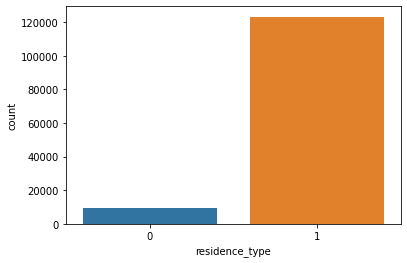

In [39]:
sns.countplot(x='residence_type', data = df1)
plt.show()
# where 1 stands for house, and 0 stands for apartment

In [40]:
count_house = len(df1[df1['residence_type']==0])
count_apt = len(df1[df1['residence_type']==1])
pct_of_house = count_house/(count_house+count_apt)
print("percentage of house is: ", pct_of_house*100)
pct_of_apt = count_apt/(count_house+count_apt)
print("percentage of apartment is: ", pct_of_apt*100)

percentage of house is:  7.179935357979674
percentage of apartment is:  92.82006464202033


Out calsses are imablanced, hence we need to balance our instances to avoid training biase.

Before we balance our dataset, we will do more observations and transform the dummy varaibels. 

In [41]:
cat_vars = ['year','month','SA2_CODE']
dfDummies = pd.get_dummies(df1, columns=cat_vars)

In [42]:
dfDummies.head()

,nbed,nbath,ncar,weekly_rent,residence_type,year_2013,year_2014,year_2015,year_2016,year_2017,...,SA2_CODE_217031471,SA2_CODE_217031472,SA2_CODE_217031473,SA2_CODE_217031474,SA2_CODE_217031475,SA2_CODE_217031476,SA2_CODE_217041477,SA2_CODE_217041478,SA2_CODE_217041479,SA2_CODE_217041480
0,4.0,1.0,1,375,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.0,1.0,1,375,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,1.0,2,340,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,2.0,0,350,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1.0,0,330,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
dfDummies.isnull().sum().sum()

0

In [44]:
X = dfDummies.loc[:, dfDummies.columns != 'residence_type']
y = dfDummies.loc[:, dfDummies.columns == 'residence_type']

We use 'SMOTE' method to over sample our apartment type dataset: https://arxiv.org/pdf/1106.1813.pdf

In [45]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['residence_type'])
# we can Check the numbers of our data
print("length of total oversampled data is ",len(os_data_X))
print("Number of apartment in oversampled data",len(os_data_y[os_data_y['residence_type']==0]))
print("Number of house",len(os_data_y[os_data_y['residence_type']==1]))
print("Proportion of apartment in oversampled data is ",len(os_data_y[os_data_y['residence_type']==0])/len(os_data_X))
print("Proportion of house data in oversampled data is ",len(os_data_y[os_data_y['residence_type']==1])/len(os_data_X))

length of total oversampled data is  172458
Number of apartment in oversampled data 86229
Number of house 86229
Proportion of apartment in oversampled data is  0.5
Proportion of house data in oversampled data is  0.5


In [46]:
dfDummies.columns

Index(['nbed', 'nbath', 'ncar', 'weekly_rent', 'residence_type', 'year_2013',
       'year_2014', 'year_2015', 'year_2016', 'year_2017',
       ...
       'SA2_CODE_217031471', 'SA2_CODE_217031472', 'SA2_CODE_217031473',
       'SA2_CODE_217031474', 'SA2_CODE_217031475', 'SA2_CODE_217031476',
       'SA2_CODE_217041477', 'SA2_CODE_217041478', 'SA2_CODE_217041479',
       'SA2_CODE_217041480'],
      dtype='object', length=526)

In [47]:
data_final_vars=dfDummies.columns.values.tolist()
y=['residence_type']
X=[i for i in data_final_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()


In [48]:
X = os_data_X.loc[:, os_data_X.columns != 'residence_type']
y = os_data_X.loc[:, os_data_X.columns == 'residence_type']

In [49]:
os_data_X.shape

(172458, 525)

In [50]:
os_data_y.shape

(172458, 1)

## Feature selection

remove features with p-value greater than 0.05

In [51]:
X = os_data_X
y = os_data_y

In [52]:
# further feature selection if have time
'''logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())'''

'logit_model=sm.Logit(y,X)\nresult=logit_model.fit()\nprint(result.summary2())'

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train.values.ravel())

/Users/graceliu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [54]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.88


## Evalutation

In [55]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[23491  2564]
 [ 3414 22269]]


In [56]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89     26055
           1       0.90      0.87      0.88     25683

    accuracy                           0.88     51738
   macro avg       0.88      0.88      0.88     51738
weighted avg       0.88      0.88      0.88     51738



## Apply the prediction result to the original dataframe

In [57]:
df_other.head()

,nbed,nbath,ncar,weekly_rent,residence_type,year,month,SA2_CODE
14,3.0,1.0,4,280,Other,2018,9,205011078
15,2.0,1.0,2,220,Other,2018,12,204031070
20,4.0,2.0,4,450,Other,2018,12,204031070
28,2.0,1.0,4,200,Other,2018,1,204031070
30,2.0,1.0,1,380,Other,2018,4,211051275


In [58]:
df_other[df_other.SA2_CODE == 206061515]


,nbed,nbath,ncar,weekly_rent,residence_type,year,month,SA2_CODE
87905,1.0,1.0,0,325,Other,2022,7,206061515
87906,1.0,1.0,0,325,Other,2022,2,206061515


In [59]:
predict_df = df_other[~df_other.SA2_CODE.isin([East_Melbourne,West_Melbourne,South_Yarra])]
mannual_predict_df = df_other[df_other.SA2_CODE.isin([East_Melbourne,West_Melbourne,South_Yarra])]
# This part was explained in the previous part. We mannually googled and judged all these properties can be apartment in these suburbs

In [60]:
mannual_predict_df['residence_type'] = 'Apartment'

<ipython-input-60-9d85c6242bc0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mannual_predict_df['residence_type'] = 'Apartment'


In [61]:
cat_vars = ['year','month','SA2_CODE']
dfDummies2 = pd.get_dummies(predict_df, columns=cat_vars)

In [62]:
X = dfDummies2.loc[:, dfDummies2.columns != 'residence_type']
y = dfDummies2.loc[:, dfDummies2.columns == 'residence_type']

In [63]:
result = list(logreg.predict(X))

In [64]:
predict_df['residence_type'] = result

<ipython-input-64-4b0b1fd5d47c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['residence_type'] = result


In [65]:
predict_df.head()

,nbed,nbath,ncar,weekly_rent,residence_type,year,month,SA2_CODE
14,3.0,1.0,4,280,1,2018,9,205011078
15,2.0,1.0,2,220,0,2018,12,204031070
20,4.0,2.0,4,450,1,2018,12,204031070
28,2.0,1.0,4,200,1,2018,1,204031070
30,2.0,1.0,1,380,0,2018,4,211051275


In [66]:
predict_df['residence_type'] = predict_df['residence_type'].apply(lambda x: 'House' if x == 1 else 'Apartment')

<ipython-input-66-92e4264e5789>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['residence_type'] = predict_df['residence_type'].apply(lambda x: 'House' if x == 1 else 'Apartment')


In [67]:
predict_df

,nbed,nbath,ncar,weekly_rent,residence_type,year,month,SA2_CODE
14,3.0,1.0,4,280,House,2018,9,205011078
15,2.0,1.0,2,220,Apartment,2018,12,204031070
20,4.0,2.0,4,450,House,2018,12,204031070
28,2.0,1.0,4,200,House,2018,1,204031070
30,2.0,1.0,1,380,Apartment,2018,4,211051275
...,...,...,...,...,...,...,...,...
231490,3.0,1.0,1,250,House,2017,10,205041094
231491,3.0,1.0,1,280,House,2017,7,205041094
231493,2.0,2.0,1,195,House,2017,5,205041094
231495,3.0,2.0,2,300,House,2017,1,205041094


In [68]:
predict_result = pd.concat([predict_df, mannual_predict_df])

In [69]:
# check if we've predicted all 'Other' type data
initial_other_df = combine_df[combine_df.residence_type == 'Other']
len(predict_result) == len(initial_other_df)
# Yes, we did

True

In [70]:
pred_type = predict_result['residence_type']

In [71]:
pred_df = pd.merge(combine_df, pred_type, left_index=True, right_index=True)
pred_df.columns

Index(['Unnamed: 0.3', 'Unnamed: 0', 'Unnamed: 0.2', 'Unnamed: 0.1', 'address',
       'latitude', 'longitude', 'nbed', 'nbath', 'ncar', 'price', 'type',
       'historical_dates', 'postcode', 'year', 'month', 'suburb',
       'weekly_rent', 'residence_type_x', 'SA2_CODE', 'residence_type_y'],
      dtype='object')

In [72]:
pred_df = pred_df.drop(columns='residence_type_x')

In [73]:
pred_df = pred_df.rename(columns={'residence_type_y':'residence_type'})

combine the house & apt dataset with predicted data set

In [74]:
house_apt_df = combine_df[combine_df.residence_type != 'Other']

In [75]:
result = pd.concat([pred_df, house_apt_df])

In [76]:
# Check if there are data loss
len(result) == len(combine_df)
# No loss

True

In [77]:
result = result.drop(columns=['Unnamed: 0.3','Unnamed: 0','Unnamed: 0.2','Unnamed: 0.1','type'])

In [82]:
import os
new_path = '../../data/curated/property_all_with_SA2_classified'
if not os.path.exists(new_path) :
    os.makedirs(new_path)

In [85]:
YEAR = list(result.year.unique())
for year in YEAR:
    df = result[result.year == year]
    df.to_csv(f'../../data/curated/property_all_with_SA2_classified/{year}_property_with_SA2_classified.csv')